### Imports

In [52]:
import jax
import jax.numpy as jnp
import numpy as np

from parsmooth.models.bearings import get_data, make_parameters, plot_bearings
from parsmooth.parallel import ckf, cks, icks
from parsmooth.sequential import ckf as seq_ckf, cks as seq_cks, icks as seq_icks
from parsmooth.utils import MVNormalParameters

jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)

np.random.seed(0)

### Input parameters

In [53]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 1000  # number of observations

### Get parameters

In [54]:
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

### Get data

In [55]:
ts, true_states, observations = get_data(x0, dt, r, T, s1, s2, random_state=42)

### We can now run the filter and smoother

Initial state guess

In [56]:
m = jnp.array([-1., -1., 0., 0., 0.])
P = jnp.eye(5)

initial_guess = MVNormalParameters(m, P)

Run the filter

In [57]:
initial_states = MVNormalParameters(np.random.randn(T + 1, 5), jnp.repeat(jnp.eye(5)[None, ...], T + 1, axis=0))

In [58]:
vec_transition_function = jnp.vectorize(transition_function, signature="(m)->(m)")
vec_observation_function = jnp.vectorize(observation_function, signature="(m)->(d)")

In [59]:
filtered = ckf(initial_guess,
               observations,
               vec_transition_function,
               Q,
               vec_observation_function,
               R,
               jax.tree_map(lambda z: z[1:], initial_states),
               propagate_first=False)

In [60]:
_, seq_filtered = seq_ckf(initial_guess,
                          observations,
                          vec_transition_function,
                          Q,
                          vec_observation_function,
                          R,
                          jax.tree_map(lambda z: z[1:], initial_states),
                          propagate_first=False)

In [61]:
jnp.abs(filtered.cov - seq_filtered.cov).max()

DeviceArray(5.17363929e-14, dtype=float64)

In [65]:
smoothed = cks(vec_transition_function, Q, filtered, jax.tree_map(lambda z: z[1:], initial_states),)

In [66]:
seq_smoothed = seq_cks(vec_transition_function, Q, seq_filtered, jax.tree_map(lambda z: z[1:], initial_states),)

In [67]:
jnp.abs(smoothed.cov - seq_smoothed.cov).max()

DeviceArray(3.77475828e-14, dtype=float64)

In [68]:
smoothed = cks(vec_transition_function, Q, filtered)

### And the iterated one

In [69]:
iterated_smoothed_trajectories = icks(initial_guess,
                                      observations,
                                      vec_transition_function,
                                      Q,
                                      vec_observation_function,
                                      R,
                                      initial_states,
                                      n_iter=15)

### For comparison we can run the sequential iterated smoother too

In [70]:
seq_iterated_smoothed_trajectories = seq_icks(initial_guess,
                                              observations,
                                              vec_transition_function,
                                              Q,
                                              vec_observation_function,
                                              R,
                                              initial_states,
                                              n_iter=15, propagate_first=True)

In [75]:
not_prop_iterated_smoothed_trajectories = icks(initial_guess,
                                               observations,
                                               vec_transition_function,
                                               Q,
                                               vec_observation_function,
                                               R,
                                               jax.tree_map(lambda z: z[1:], initial_states),
                                               n_iter=15, propagate_first=False)

In [76]:
seq_not_prop_iterated_smoothed_trajectories = seq_icks(initial_guess,
                                                       observations,
                                                       vec_transition_function,
                                                       Q,
                                                       vec_observation_function,
                                                       R,
                                                       jax.tree_map(lambda z: z[1:], initial_states),
                                                       n_iter=15, propagate_first=False)

### Plot the result

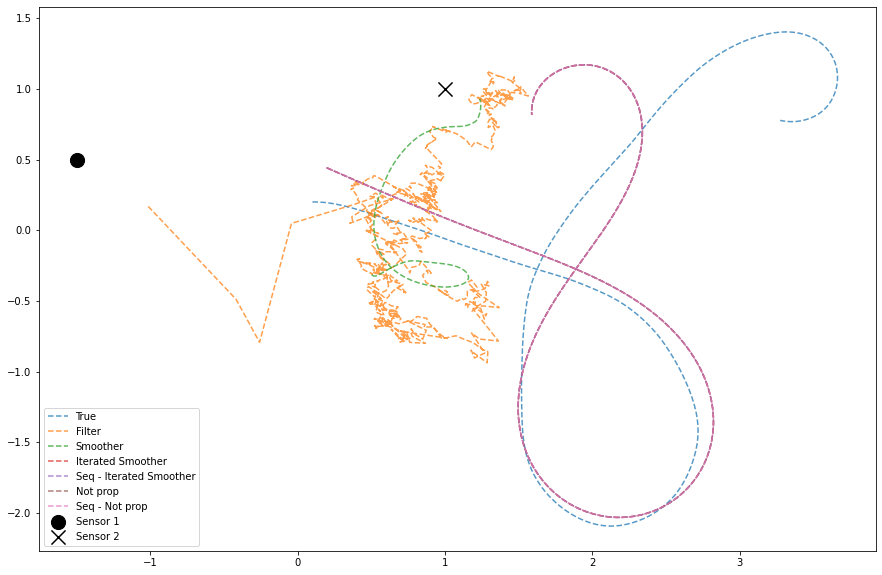

In [77]:
plot_bearings([true_states, filtered.mean, smoothed.mean, iterated_smoothed_trajectories.mean,
               seq_iterated_smoothed_trajectories.mean, not_prop_iterated_smoothed_trajectories.mean,
               seq_not_prop_iterated_smoothed_trajectories.mean],
              ["True", "Filter", "Smoother", "Iterated Smoother", "Seq - Iterated Smoother", "Not prop",
               "Seq - Not prop"],
              s1, s2, figsize=(15, 10), quiver=False)

In [78]:
np.abs(seq_not_prop_iterated_smoothed_trajectories.mean - not_prop_iterated_smoothed_trajectories.mean).max()


2.1604940059205546e-13

In [79]:
np.abs(seq_iterated_smoothed_trajectories.mean - iterated_smoothed_trajectories.mean).max()


2.0543566847663897e-12